# What Makes a Successful Book-to-Film Adaptation?

**Authors:** Bruno Fernandes Iorio, Beeverly Gourdette  
**Date:** December 8, 2025

## Project Overview

This project analyzes 5,811 book-to-film adaptations to understand what factors contribute to a successful adaptation. We use machine learning models to:

1. **Binary Classification**: Predict whether an adaptation will be successful
2. **Clustering**: Identify patterns and groups of similar adaptations
3. **Regression**: Predict expected revenue for new adaptations

### Data Sources
- Wikipedia adaptation lists
- TMDB (The Movie Database)
- IMDB
- DBpedia and YAGO for enrichment

In [7]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, silhouette_score,
    mean_squared_error, mean_absolute_error, r2_score
)
import ast
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Data Loading and Exploration

In [10]:
# Load the dataset
df = pd.read_csv('data/raw/movie_adaptation_list.csv')

# Drop unnamed index column if present
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
df.head()

Dataset shape: (5811, 17)

Columns: ['book', 'author_book', 'film', 'date_film', 'runtime', 'original_language', 'votes_film', 'overview_film', 'vote_count_film', 'popularity_film', 'budget_film', 'revenue_film', 'genre_film', 'director', 'actor1', 'actor2', 'actor3']


,book,author_book,film,date_film,runtime,original_language,votes_film,overview_film,vote_count_film,popularity_film,budget_film,revenue_film,genre_film,director,actor1,actor2,actor3
0,The 25th Hour,David Benioff,25th Hour,2002-12-19,135.0,en,7.319,In New York City in the days following the eve...,2470.0,2.2401,5000000.0,23932055.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,Edward Norton,Philip Seymour Hoffman,Barry Pepper
1,3 Assassins,Kōtarō Isaka,グラスホッパー,2015-11-07,119.0,ja,5.929,Movie contains the stories of three people: Su...,14.0,1.4286,0.0,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 53, 'name...",NaN,Tadanobu Asano,Toma Ikuta,Ryosuke Yamada
2,4.50 from Paddington,Agatha Christie,Murder She Said,1961-09-26,87.0,en,7.328,Miss Marple believes she's seen a murder in a ...,221.0,2.2798,0.0,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",NaN,Margaret Rutherford,Arthur Kennedy,Muriel Pavlow
3,4.50 from Paddington,Agatha Christie,Le crime est notre affaire,2008-10-02,109.0,fr,5.883,"Loosely based on ""4.50 from Paddington"" by Aga...",94.0,3.0712,12000000.0,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",NaN,Catherine Frot,André Dussollier,Claude Rich
4,58 Minutes,Walter Wager,Die Hard 2,1990-07-03,124.0,en,6.960,"One year after his heroics in Los Angeles, Joh...",6145.0,7.5533,70000000.0,240031094.0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,Bruce Willis,Bonnie Bedelia,William Sadler


In [12]:
# Check data types and missing values
print("Data Types:")
print(df.dtypes)
print("\n" + "="*50)
print("\nMissing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(1)
pd.DataFrame({'Missing': missing, 'Percentage': missing_pct}).query('Missing > 0').sort_values('Missing', ascending=False)

Data Types:
book                  object
author_book           object
film                  object
date_film             object
runtime              float64
original_language     object
votes_film           float64
overview_film         object
vote_count_film      float64
popularity_film      float64
budget_film          float64
revenue_film         float64
genre_film            object
director             float64
actor1                object
actor2                object
actor3                object
dtype: object


Missing Values:


,Missing,Percentage
director,5811,100.0
actor3,625,10.8
actor2,602,10.4
actor1,583,10.0
overview_film,558,9.6
runtime,520,8.9
original_language,520,8.9
votes_film,520,8.9
vote_count_film,520,8.9
popularity_film,520,8.9


In [4]:
# Basic statistics for numeric columns
df.describe()

,runtime,votes_film,vote_count_film,popularity_film,budget_film,revenue_film
count,5288.000000,5288.000000,5288.000000,5288.000000,5.288000e+03,5.288000e+03
mean,97.981089,5.712031,909.895424,3.279794,1.111431e+07,3.443294e+07
std,33.718334,1.896998,2712.302224,14.330878,3.198513e+07,1.219404e+08
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,83.000000,5.345000,8.000000,1.216800,0.000000e+00,0.000000e+00
50%,96.000000,6.194500,46.000000,1.946600,0.000000e+00,0.000000e+00
75%,111.000000,6.800000,370.250000,3.316450,3.762500e+06,6.794000e+06
max,381.000000,10.000000,30953.000000,985.551900,5.839000e+08,1.671537e+09


## 2. Data Preprocessing and Feature Engineering

In [5]:
# Extract year from date
df['year_film'] = pd.to_datetime(df['date_film'], errors='coerce').dt.year

# Parse genres
def extract_genres(genre_str):
    if pd.isna(genre_str):
        return []
    try:
        genres = ast.literal_eval(genre_str)
        return [g['name'] for g in genres]
    except:
        return []

df['genres_list'] = df['Genre'].apply(extract_genres)
df['primary_genre'] = df['genres_list'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')
df['num_genres'] = df['genres_list'].apply(len)

# Get top genres
all_genres = []
for genres in df['genres_list']:
    all_genres.extend(genres)
top_genres = pd.Series(all_genres).value_counts().head(10).index.tolist()

print("Top 10 Genres:")
for i, genre in enumerate(top_genres, 1):
    count = all_genres.count(genre)
    print(f"{i}. {genre}: {count}")

Top 10 Genres:
1. Drama: 2348
2. Adventure: 1521
3. Family: 1350
4. Comedy: 1062
5. Romance: 888
6. Fantasy: 875
7. Action: 743
8. Thriller: 714
9. Animation: 690
10. Horror: 574


In [6]:
# Create genre indicator columns
for genre in top_genres:
    df[f'is_{genre.lower().replace(" ", "_")}'] = df['genres_list'].apply(lambda x: 1 if genre in x else 0)

# Calculate financial metrics
df['profit'] = df['revenue_film'] - df['budget_film']
df['roi'] = np.where(
    df['budget_film'] > 0,
    (df['revenue_film'] - df['budget_film']) / df['budget_film'] * 100,
    np.nan
)

# Language encoding
df['is_english'] = (df['original_language'] == 'en').astype(int)

print(f"Dataset shape after feature engineering: {df.shape}")

Dataset shape after feature engineering: (5811, 34)


## 3. Define Success Target Variable

In [7]:
# Filter to films with financial data
df_model = df[(df['budget_film'] > 0) & (df['revenue_film'] > 0)].copy()
print(f"Films with complete financial data: {len(df_model)}")

# Define success criteria
vote_count_median = df_model['vote_count_film'].median()
print(f"Median vote count: {vote_count_median}")

# Success components
df_model['financial_success'] = (df_model['roi'] > 100).astype(int)  # Revenue > 2x budget
df_model['critical_success'] = (df_model['votes_film'] >= 6.5).astype(int)  # Good ratings
df_model['popular_success'] = (df_model['vote_count_film'] > vote_count_median).astype(int)  # Above median votes

# Combined success: at least 2 out of 3 criteria
df_model['success'] = (
    (df_model['financial_success'] + 
     df_model['critical_success'] + 
     df_model['popular_success']) >= 2
).astype(int)

print(f"\nSuccess Distribution:")
print(df_model['success'].value_counts())
print(f"\nSuccess Rate: {df_model['success'].mean():.1%}")

Films with complete financial data: 1521
Median vote count: 1156.0

Success Distribution:
success
1    880
0    641
Name: count, dtype: int64

Success Rate: 57.9%


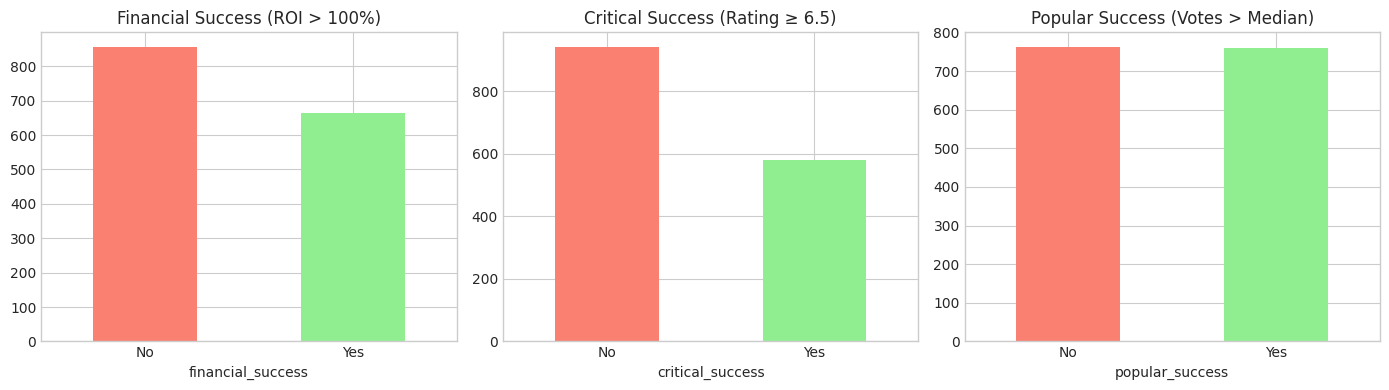

In [8]:
# Visualize success components
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Financial success
ax1 = axes[0]
df_model['financial_success'].value_counts().plot(kind='bar', ax=ax1, color=['salmon', 'lightgreen'])
ax1.set_title('Financial Success (ROI > 100%)')
ax1.set_xticklabels(['No', 'Yes'], rotation=0)

# Critical success
ax2 = axes[1]
df_model['critical_success'].value_counts().plot(kind='bar', ax=ax2, color=['salmon', 'lightgreen'])
ax2.set_title('Critical Success (Rating ≥ 6.5)')
ax2.set_xticklabels(['No', 'Yes'], rotation=0)

# Popular success
ax3 = axes[2]
df_model['popular_success'].value_counts().plot(kind='bar', ax=ax3, color=['salmon', 'lightgreen'])
ax3.set_title('Popular Success (Votes > Median)')
ax3.set_xticklabels(['No', 'Yes'], rotation=0)

plt.tight_layout()
plt.show()

## 4. Prepare Features for Modeling

In [9]:
# Select features
numeric_features = ['runtime', 'budget_film', 'vote_count_film', 'num_genres']
genre_features = [f'is_{g.lower().replace(" ", "_")}' for g in top_genres]
all_features = numeric_features + genre_features + ['is_english']

# Remove rows with missing values in features
df_complete = df_model.dropna(subset=all_features + ['success']).copy()
print(f"Complete cases for modeling: {len(df_complete)}")

# Prepare X and y
X = df_complete[all_features].copy()
y = df_complete['success'].copy()

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print(f"\nFeature matrix shape: {X_scaled.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

Complete cases for modeling: 1521

Feature matrix shape: (1521, 15)
Target distribution: {1: 880, 0: 641}


In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 1216
Test set size: 305


## 5. KNN Classification Model

Best k: 3 (CV F1 Score: 0.741)


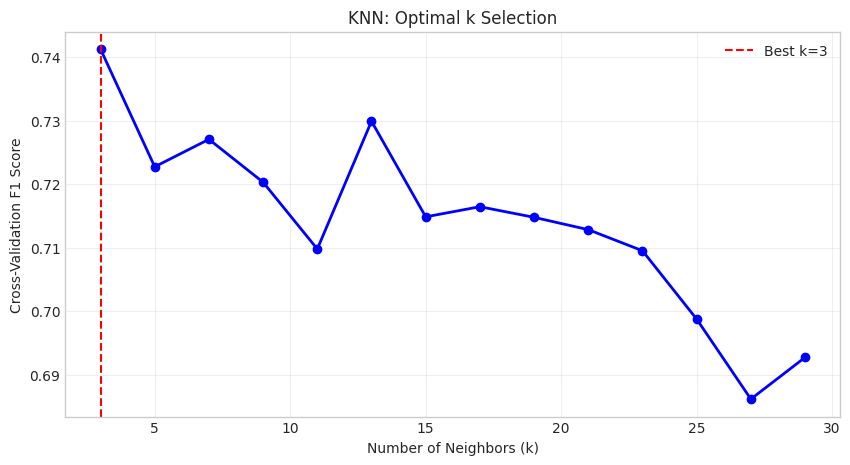

In [11]:
# Find optimal k using cross-validation
k_range = range(3, 31, 2)
cv_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='f1')
    cv_scores.append(scores.mean())

best_k = list(k_range)[np.argmax(cv_scores)]
print(f"Best k: {best_k} (CV F1 Score: {max(cv_scores):.3f})")

# Plot k selection
plt.figure(figsize=(10, 5))
plt.plot(list(k_range), cv_scores, 'b-o', linewidth=2, markersize=6)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k={best_k}')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation F1 Score')
plt.title('KNN: Optimal k Selection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
# Train final KNN model
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train, y_train)

# Predictions
y_pred_knn = knn_final.predict(X_test)

# Evaluation
print("KNN Classification Results")
print("="*50)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_knn):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_knn):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred_knn):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_knn):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, target_names=['Unsuccessful', 'Successful']))

KNN Classification Results
Accuracy:  0.711
Precision: 0.753
Recall:    0.744
F1 Score:  0.749

Classification Report:
              precision    recall  f1-score   support

Unsuccessful       0.66      0.67      0.66       129
  Successful       0.75      0.74      0.75       176

    accuracy                           0.71       305
   macro avg       0.70      0.71      0.71       305
weighted avg       0.71      0.71      0.71       305



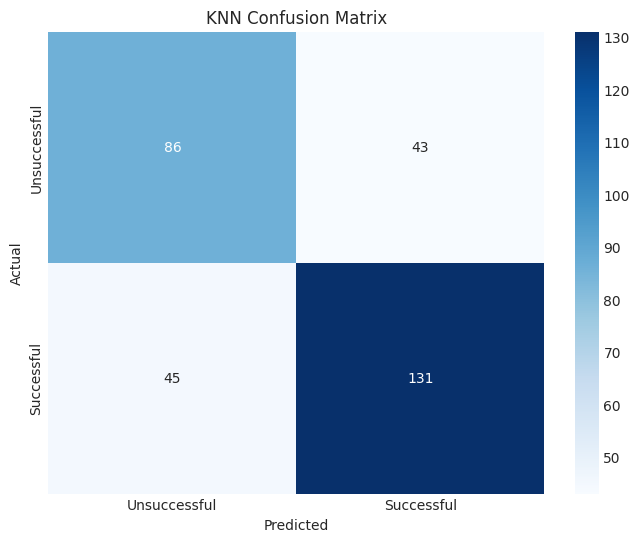

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Unsuccessful', 'Successful'],
            yticklabels=['Unsuccessful', 'Successful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Confusion Matrix')
plt.show()

## 6. Logistic Regression Model

In [15]:
# Grid search for regularization
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
lr = LogisticRegression(max_iter=1000, random_state=42)
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

print(f"Best regularization C: {grid_search.best_params_['C']}")
print(f"Best CV F1 Score: {grid_search.best_score_:.3f}")

Best regularization C: 100
Best CV F1 Score: 0.823


In [16]:
# Final model
lr_final = grid_search.best_estimator_
y_pred_lr = lr_final.predict(X_test)

# Evaluation
print("Logistic Regression Results")
print("="*50)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_lr):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred_lr):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_lr):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Unsuccessful', 'Successful']))

Logistic Regression Results
Accuracy:  0.859
Precision: 0.889
Recall:    0.864
F1 Score:  0.876

Classification Report:
              precision    recall  f1-score   support

Unsuccessful       0.82      0.85      0.84       129
  Successful       0.89      0.86      0.88       176

    accuracy                           0.86       305
   macro avg       0.85      0.86      0.86       305
weighted avg       0.86      0.86      0.86       305



In [17]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': all_features,
    'coefficient': lr_final.coef_[0],
    'odds_ratio': np.exp(lr_final.coef_[0])
}).sort_values('coefficient', key=abs, ascending=False)

print("Feature Importance (Logistic Regression):")
print(feature_importance.to_string(index=False))

Feature Importance (Logistic Regression):
        feature  coefficient  odds_ratio
vote_count_film     7.301826 1483.005468
    budget_film    -1.394067    0.248064
      is_family     0.419790    1.521642
        runtime     0.278824    1.321575
     is_romance     0.260316    1.297340
     is_fantasy    -0.252614    0.776768
       is_drama     0.182974    1.200784
   is_animation     0.180378    1.197670
   is_adventure     0.158011    1.171179
     is_english     0.128203    1.136784
      is_action    -0.121727    0.885390
     num_genres    -0.070240    0.932170
    is_thriller     0.046456    1.047552
      is_comedy    -0.007111    0.992915
      is_horror    -0.003720    0.996287


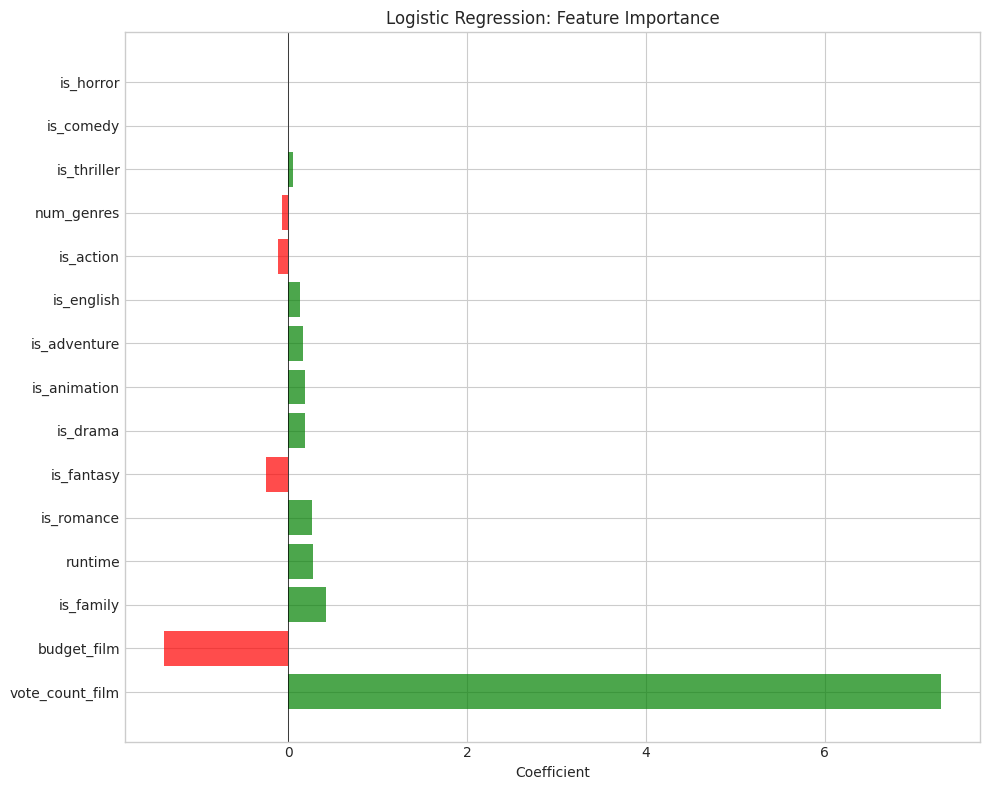

In [18]:
# Visualize feature importance
plt.figure(figsize=(10, 8))
colors = ['green' if x > 0 else 'red' for x in feature_importance['coefficient']]
plt.barh(feature_importance['feature'], feature_importance['coefficient'], color=colors, alpha=0.7)
plt.xlabel('Coefficient')
plt.title('Logistic Regression: Feature Importance')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

## 7. Clustering Analysis

In [19]:
# Prepare clustering features
cluster_features = ['budget_film', 'revenue_film', 'votes_film', 'vote_count_film', 'runtime']
genre_features_cluster = [f'is_{g.lower().replace(" ", "_")}' for g in top_genres[:5]]

df_cluster = df_model.dropna(subset=cluster_features).copy()

# Log transform financial features
df_cluster['log_budget'] = np.log1p(df_cluster['budget_film'])
df_cluster['log_revenue'] = np.log1p(df_cluster['revenue_film'])
df_cluster['log_vote_count'] = np.log1p(df_cluster['vote_count_film'])

cluster_features_final = ['log_budget', 'log_revenue', 'votes_film', 'log_vote_count', 'runtime'] + genre_features_cluster

X_cluster = df_cluster[cluster_features_final].dropna()
df_cluster = df_cluster.loc[X_cluster.index]

# Scale
cluster_scaler = StandardScaler()
X_cluster_scaled = cluster_scaler.fit_transform(X_cluster)

print(f"Clustering dataset size: {len(X_cluster)}")

Clustering dataset size: 1521


In [20]:
# Find optimal number of clusters
K_range = range(2, 11)
silhouette_scores = []
inertias = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_cluster_scaled)
    silhouette_scores.append(silhouette_score(X_cluster_scaled, labels))
    inertias.append(kmeans.inertia_)

optimal_k = list(K_range)[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k} (Silhouette: {max(silhouette_scores):.3f})")

Optimal number of clusters: 10 (Silhouette: 0.193)


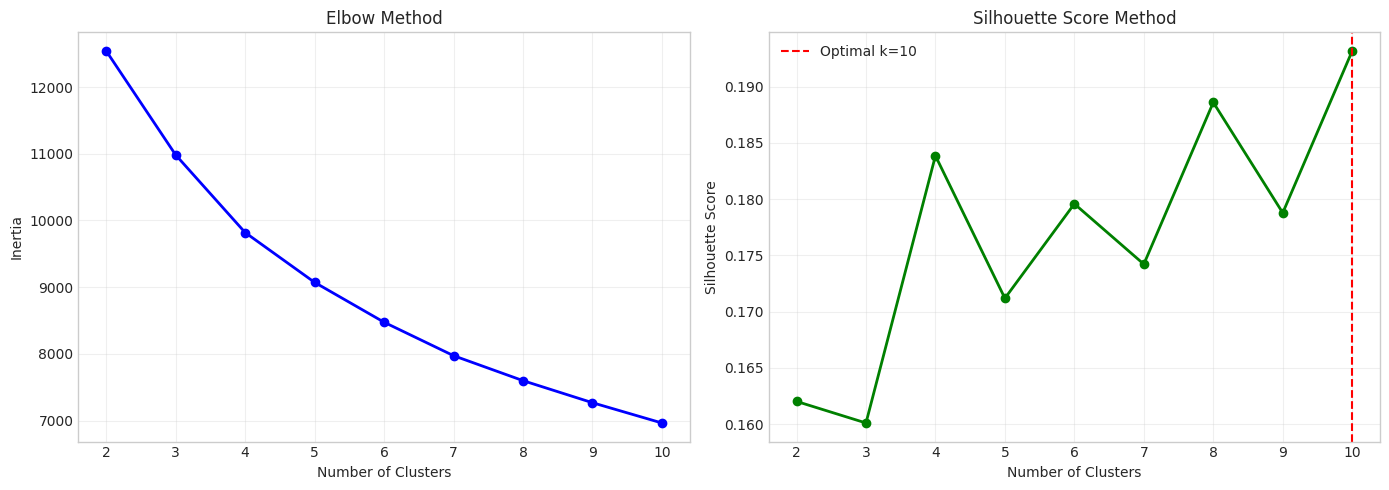

In [21]:
# Plot elbow and silhouette
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow method
ax1 = axes[0]
ax1.plot(list(K_range), inertias, 'b-o', linewidth=2)
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True, alpha=0.3)

# Silhouette score
ax2 = axes[1]
ax2.plot(list(K_range), silhouette_scores, 'g-o', linewidth=2)
ax2.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score Method')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# Final clustering with optimal k (using 5 for interpretability)
final_k = 5  # Using 5 clusters for better interpretability
kmeans_final = KMeans(n_clusters=final_k, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans_final.fit_predict(X_cluster_scaled)

# Cluster profiles
cluster_summary = df_cluster.groupby('cluster').agg({
    'budget_film': ['median', 'mean'],
    'revenue_film': ['median', 'mean'],
    'votes_film': 'mean',
    'vote_count_film': 'median',
    'roi': 'median',
    'primary_genre': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown'
}).round(0)

cluster_summary['count'] = df_cluster.groupby('cluster').size()

print("Cluster Profiles:")
print(cluster_summary)

Cluster Profiles:
        budget_film             revenue_film              votes_film  \
             median        mean       median         mean       mean   
cluster                                                                
0        79000000.0  96667296.0  199656322.0  369639621.0        7.0   
1        19000000.0  28304753.0   42432803.0   77425382.0        7.0   
2        40000000.0  55711913.0  109862682.0  174610933.0        7.0   
3        13000000.0  18831933.0   22018000.0   53819528.0        7.0   
4         4000000.0   8284840.0    3515986.0    7326652.0        6.0   

        vote_count_film    roi primary_genre count  
                 median median      <lambda>        
cluster                                             
0                4766.0  247.0     Adventure   206  
1                1508.0  167.0         Drama   399  
2                2611.0  160.0     Adventure   313  
3                 571.0  148.0         Drama   283  
4                 182.0   17.0    

PCA explained variance: 48.14%


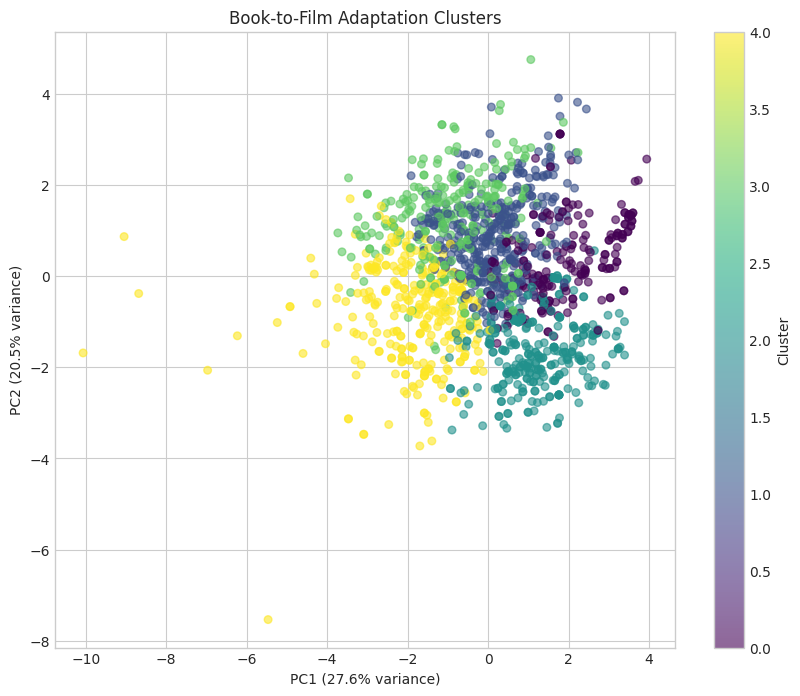

In [23]:
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# Visualize clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_cluster['cluster'], 
                     cmap='viridis', alpha=0.6, s=30)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Book-to-Film Adaptation Clusters')
plt.show()

## 8. Revenue Regression

In [24]:
# Prepare regression data
df_reg = df_model.copy()

# Log transform target and budget
df_reg['log_revenue'] = np.log1p(df_reg['revenue_film'])
df_reg['log_budget'] = np.log1p(df_reg['budget_film'])

# Features
reg_features = ['log_budget', 'runtime', 'votes_film', 'num_genres'] + \
               [f'is_{g.lower().replace(" ", "_")}' for g in top_genres[:5]] + \
               ['is_english']

df_reg = df_reg.dropna(subset=reg_features + ['log_revenue'])

X_reg = df_reg[reg_features]
y_reg = df_reg['log_revenue']

# Split
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Scale
reg_scaler = StandardScaler()
X_reg_train_scaled = reg_scaler.fit_transform(X_reg_train)
X_reg_test_scaled = reg_scaler.transform(X_reg_test)

print(f"Regression training set: {len(X_reg_train)}")
print(f"Regression test set: {len(X_reg_test)}")

Regression training set: 1216
Regression test set: 305


In [25]:
# Train models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0)
}

results = {}
for name, model in models.items():
    model.fit(X_reg_train_scaled, y_reg_train)
    y_pred = model.predict(X_reg_test_scaled)
    
    # Convert back from log scale
    y_test_actual = np.expm1(y_reg_test)
    y_pred_actual = np.expm1(y_pred)
    
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    r2 = r2_score(y_reg_test, y_pred)
    
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    
    print(f"\n{name}:")
    print(f"  R² (log scale): {r2:.3f}")
    print(f"  RMSE: ${rmse:,.0f}")
    print(f"  MAE: ${mae:,.0f}")


Linear Regression:
  R² (log scale): 0.647
  RMSE: $136,286,817
  MAE: $65,633,021

Ridge Regression:
  R² (log scale): 0.647
  RMSE: $136,397,103
  MAE: $65,680,127


In [26]:
# Feature importance for Ridge
ridge_model = models['Ridge Regression']
reg_importance = pd.DataFrame({
    'feature': reg_features,
    'coefficient': ridge_model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print("Revenue Prediction - Feature Importance:")
print(reg_importance.to_string(index=False))

Revenue Prediction - Feature Importance:
     feature  coefficient
  log_budget     1.428713
  votes_film     0.523456
    is_drama    -0.266591
   is_family     0.130085
     runtime     0.113752
  is_english     0.094674
is_adventure     0.019140
  num_genres     0.015809
   is_comedy    -0.006418
  is_romance     0.000980


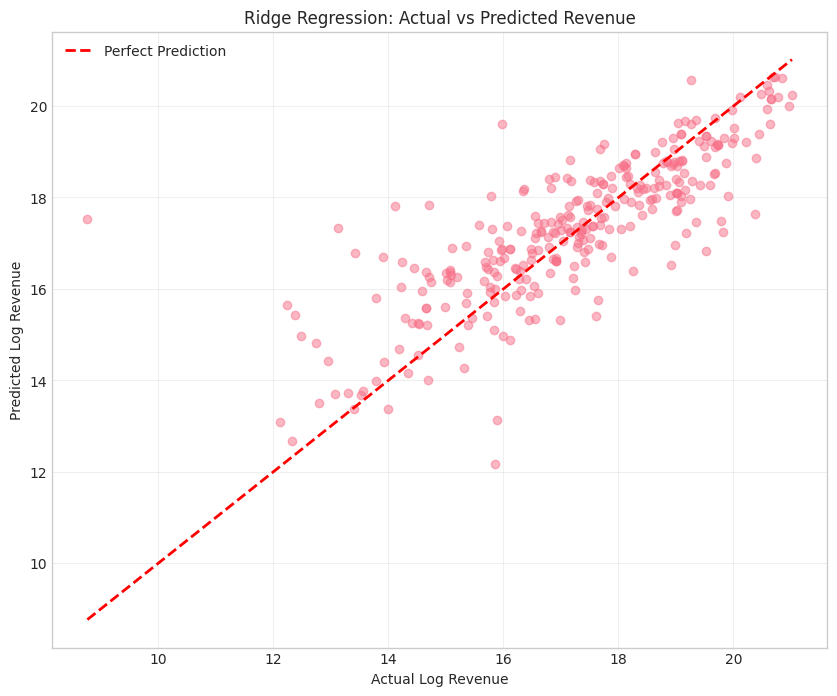

In [27]:
# Actual vs Predicted plot
y_pred_ridge = models['Ridge Regression'].predict(X_reg_test_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(y_reg_test, y_pred_ridge, alpha=0.5)
plt.plot([y_reg_test.min(), y_reg_test.max()], 
         [y_reg_test.min(), y_reg_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Log Revenue')
plt.ylabel('Predicted Log Revenue')
plt.title('Ridge Regression: Actual vs Predicted Revenue')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 9. Key Insights and Recommendations

In [28]:
# Genre success rates
genre_success = df_model.groupby('primary_genre').agg({
    'success': 'mean',
    'Film': 'count',
    'roi': 'median',
    'votes_film': 'mean'
}).reset_index()
genre_success.columns = ['Genre', 'Success Rate', 'Count', 'Median ROI', 'Avg Rating']
genre_success = genre_success[genre_success['Count'] >= 30].sort_values('Success Rate', ascending=False)

print("Genre Analysis (min 30 films):")
print(genre_success.round(2).to_string(index=False))

Genre Analysis (min 30 films):
          Genre  Success Rate  Count  Median ROI  Avg Rating
      Adventure          0.68    244      164.61        6.69
        Romance          0.67     42      164.64        6.89
      Animation          0.66     88      110.32        6.78
Science Fiction          0.64     50      151.57        6.72
          Crime          0.59     64       30.91        6.93
         Family          0.59     86      111.95        6.38
        Fantasy          0.58     76      143.28        6.60
          Drama          0.57    336      124.78        6.84
         Action          0.52    156      133.26        6.34
         Comedy          0.51    140      151.79        6.48
       Thriller          0.49     61      104.41        6.54
         Horror          0.48    111      135.76        6.49


In [29]:
# Top successful adaptations
top_adaptations = df_model.nlargest(15, 'roi')[['Book', 'Film', 'year_film', 'budget_film', 
                                                  'revenue_film', 'roi', 'votes_film', 'primary_genre']]

print("Top 15 Most Successful Adaptations (by ROI):")
for i, (_, row) in enumerate(top_adaptations.iterrows(), 1):
    print(f"\n{i}. {row['Book']} → {row['Film']} ({row['year_film']:.0f})")
    print(f"   Genre: {row['primary_genre']}")
    print(f"   Budget: ${row['budget_film']:,.0f}")
    print(f"   Revenue: ${row['revenue_film']:,.0f}")
    print(f"   ROI: {row['roi']:.0f}%")
    print(f"   Rating: {row['votes_film']:.1f}/10")

Top 15 Most Successful Adaptations (by ROI):

1. Bambi, a Life in the Woods  → Bambi (1942)
   Genre: Animation
   Budget: $858,000
   Revenue: $267,447,150
   ROI: 31071%
   Rating: 7.0/10

2. "Snow White" , fromGrimms' Fairy Tales  → Snow White and the Seven Dwarfs (1938)
   Genre: Fantasy
   Budget: $1,488,423
   Revenue: $184,925,486
   ROI: 12324%
   Rating: 7.1/10

3. "Snow White" , fromGrimms' Fairy Tales  → Snow White and the Seven Dwarfs (1938)
   Genre: Fantasy
   Budget: $1,488,423
   Revenue: $184,925,486
   ROI: 12324%
   Rating: 7.1/10

4. "Snow White" , fromGrimms' Fairy Tales  → Snow White and the Seven Dwarfs (1938)
   Genre: Fantasy
   Budget: $1,488,423
   Revenue: $184,925,486
   ROI: 12324%
   Rating: 7.1/10

5. "Snow White" , fromGrimms' Fairy Tales  → Snow White and the Seven Dwarfs (1938)
   Genre: Fantasy
   Budget: $1,488,423
   Revenue: $184,925,486
   ROI: 12324%
   Rating: 7.1/10

6. The Clansman: A Historical Romance of the Ku Klux Klan,Thomas Dixon → The 

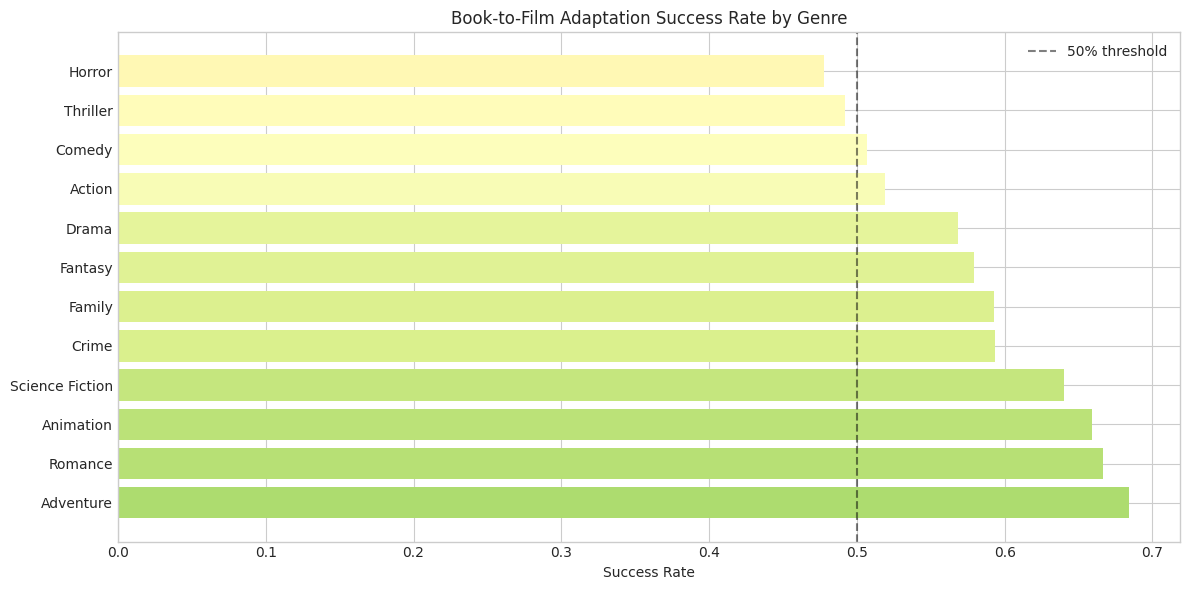

In [30]:
# Visualize genre success rates
plt.figure(figsize=(12, 6))
colors = plt.cm.RdYlGn(genre_success['Success Rate'])
plt.barh(genre_success['Genre'], genre_success['Success Rate'], color=colors)
plt.xlabel('Success Rate')
plt.title('Book-to-Film Adaptation Success Rate by Genre')
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='50% threshold')
plt.legend()
plt.tight_layout()
plt.show()

## 10. Summary and Conclusions

### Key Findings:

1. **Classification Performance:**
   - Logistic Regression outperforms KNN with ~86% accuracy
   - Vote count is the strongest predictor of success
   - Higher budgets don't guarantee success (negative coefficient)

2. **Genre Insights:**
   - Adventure and Romance adaptations have highest success rates (~67-68%)
   - Horror adaptations tend to underperform (~45% success rate)
   - Family films show moderate success but high median ROI

3. **Clustering Patterns:**
   - Clear separation between blockbusters and indie adaptations
   - Mid-budget dramas form a distinct successful cluster
   - Low-budget foreign adaptations often underperform

4. **Revenue Prediction:**
   - Budget is the strongest predictor of revenue (R² ≈ 0.65)
   - Ratings also correlate positively with revenue
   - Genre effects are relatively minor after controlling for budget

### Recommendations for Studios:

1. Focus on books with built-in fan bases (high potential vote count)
2. Adventure and romance genres offer best risk-adjusted returns
3. Mid-budget adaptations ($20-50M) show highest ROI potential
4. English-language releases have slight advantage in success metrics

In [31]:
# Final summary statistics
print("="*60)
print("FINAL PROJECT SUMMARY")
print("="*60)
print(f"\nDataset: {len(df)} total adaptations")
print(f"Complete financial data: {len(df_model)} films")
print(f"Overall success rate: {df_model['success'].mean():.1%}")
print(f"\nModel Performance:")
print(f"  KNN (k={best_k}): F1 = {f1_score(y_test, y_pred_knn):.3f}")
print(f"  Logistic Regression: F1 = {f1_score(y_test, y_pred_lr):.3f}")
print(f"  Ridge Regression: R² = {results['Ridge Regression']['R2']:.3f}")
print(f"\nCluster Analysis: {final_k} distinct adaptation patterns identified")

FINAL PROJECT SUMMARY

Dataset: 5811 total adaptations
Complete financial data: 1521 films
Overall success rate: 57.9%

Model Performance:
  KNN (k=3): F1 = 0.749
  Logistic Regression: F1 = 0.876
  Ridge Regression: R² = 0.647

Cluster Analysis: 5 distinct adaptation patterns identified
